In [2]:
import os
import sys
import warnings

import torch
import shap
import pandas as pd
import numpy as np

from devnet.trainer import Model, Trainer

shap.initjs()
warnings.simplefilter("ignore")

In [ ]:
%cd ..

In [5]:
model_path = "data/debug/models/example.pth"
loaded_data = torch.load(model_path, map_location="cpu")

model = Model(loaded_data["n_input"], loaded_data["model"])
model.eval()

@torch.no_grad()
def f(X):
    return model(torch.tensor(np.array(X), dtype=torch.float)).numpy()

In [17]:
data_path = "data/debug/eval.csv"
df_all = pd.read_csv(data_path)
df_all.describe()

,Dim_0,Dim_1=0,Dim_2=0,Dim_3=0,Dim_4=0,Dim_5=0,Dim_6=0,Dim_7=0,Dim_8=0,Dim_9=0,...,Dim_12=0,Dim_13=0,Dim_14=0,Dim_15=0,Dim_16,Dim_17,Dim_18,Dim_19,Dim_20,class
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,...,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.533116,0.704861,0.881250,0.984722,0.989583,0.959028,0.992361,0.979861,0.979861,0.928472,...,0.987500,0.973611,0.999306,0.952083,0.008648,0.107180,0.177237,0.372512,0.171833,0.074306
std,0.198645,0.456264,0.323606,0.122698,0.101564,0.198295,0.087097,0.140524,0.140524,0.257794,...,0.111141,0.160345,0.026352,0.213664,0.037668,0.039859,0.063405,0.085334,0.058595,0.262359
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009259,0.000000,0.000000
25%,0.375000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.001434,0.091922,0.142140,0.324074,0.142188,0.000000
50%,0.552083,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.003208,0.109192,0.173913,0.365741,0.168750,0.000000
75%,0.697917,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.004906,0.119777,0.204013,0.402778,0.193750,0.000000
max,0.968750,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.932075,0.737604,1.000000,0.796296,0.850000,1.000000


In [23]:
df_class0 = df_all[df_all["class"] == 0].drop(columns=["class"])
df_class1 = df_all[df_all["class"] == 1].drop(columns=["class"])

df_all.loc[:, "class"].value_counts()

0    1333
1     107
Name: class, dtype: int64

In [24]:
background_samples = df_class0.iloc[:50, :]
samples = df_class1

In [26]:
clustering = shap.utils.hclust(df_all.drop(columns=["class"]), df_all["class"])

masker = shap.maskers.Partition(background_samples)
explainer = shap.PermutationExplainer(f, masker)
explanations = explainer(samples)

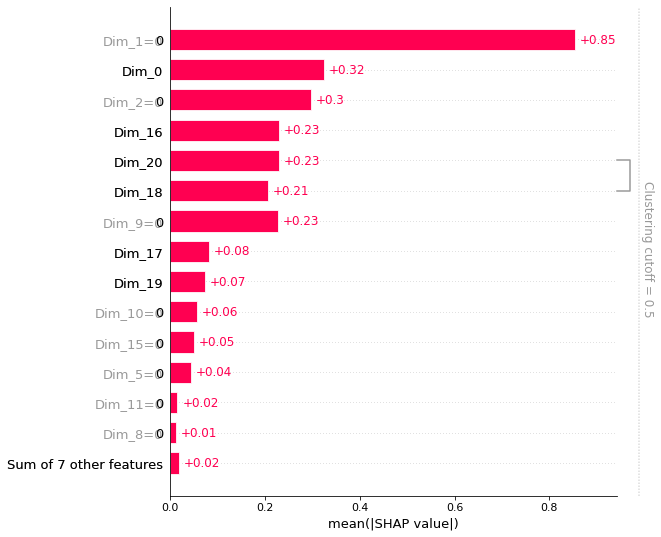

In [29]:
# 各特徴量の予測値への平均寄与率
shap.plots.bar(explanations, max_display=15, clustering=clustering, clustering_cutoff=0.5);

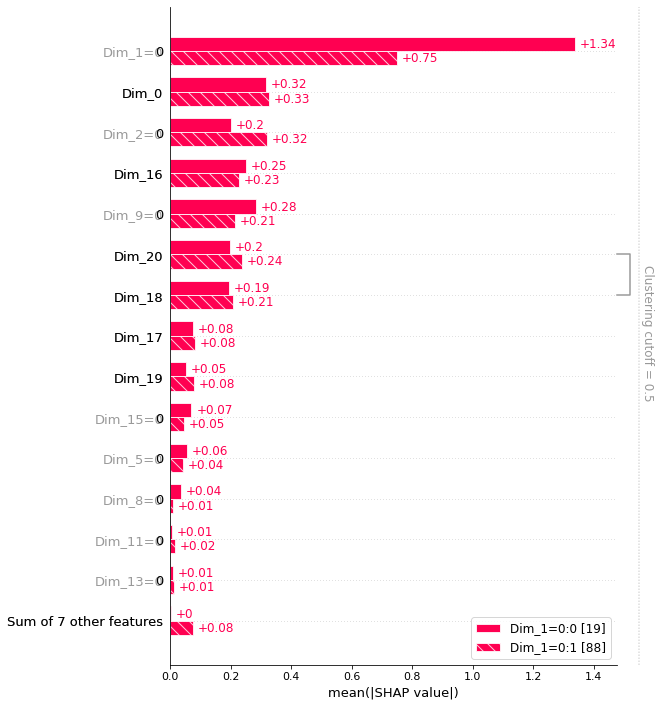

In [31]:
def d(entry):
    if entry["Dim_1=0"] == 0:
        return "Dim_1=0:0"
    return "Dim_1=0:1"

dim1 = [d(samples.iloc[i]) for i in range(len(samples))]
shap.plots.bar(explanations.cohorts(dim1).abs.mean(0), max_display=15, clustering=clustering, clustering_cutoff=0.5)

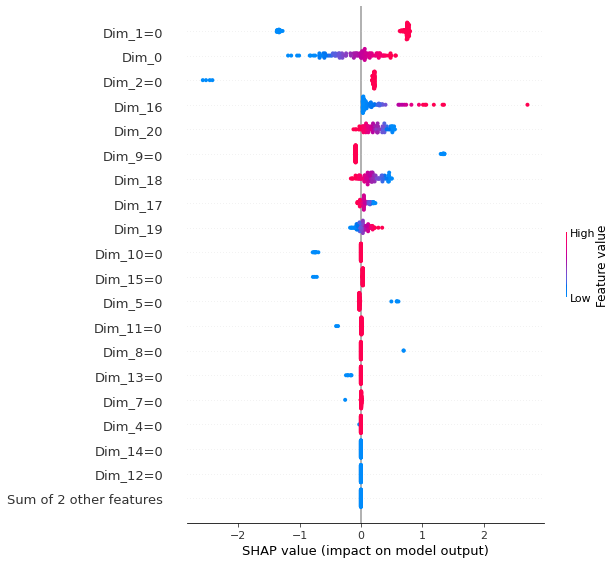

In [32]:
# 上記に加えて特徴量の増減と予測値の増減の関係
shap.plots.beeswarm(explanations, max_display=20);

In [33]:
# サンプル毎の各特徴量の予測値への寄与率
shap.plots.force(explanations.base_values[0], explanations.values, samples)

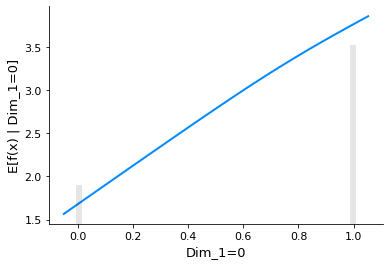

In [34]:
# 指定した特徴量の変化に対する予測値の変化(samplesの平均)
shap.plots.partial_dependence("Dim_1=0", f, samples, ice=False)

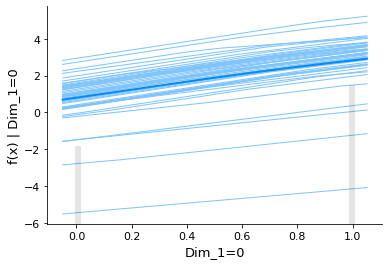

In [ ]:
# 指定した特徴量の変化に対する予測値の変化(samples毎)
@torch.no_grad()
def g(X):
    preds = model(torch.tensor(np.array(X), dtype=torch.float))
    return preds.squeeze().numpy()
shap.plots.partial_dependence("Dim_1=0", g, samples, ice=True, feature_names=samples.columns)

### Old API (shap 0.36以前)

In [8]:
explainer = shap.KernelExplainer(f, background_samples)
shap_values = explainer.shap_values(samples, nsamples=50)

  0%|          | 0/50 [00:00<?, ?it/s]

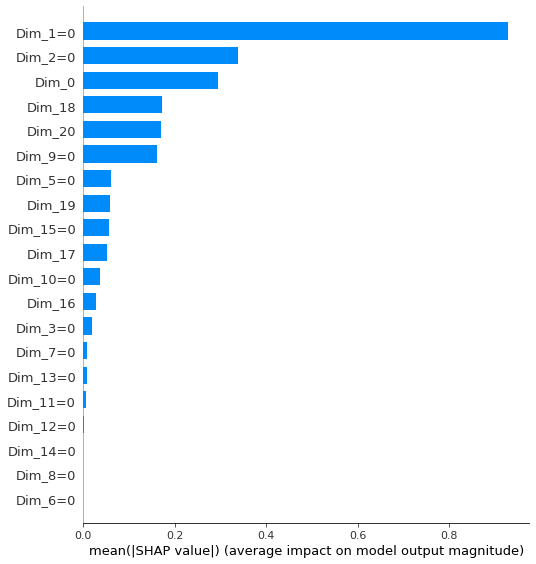

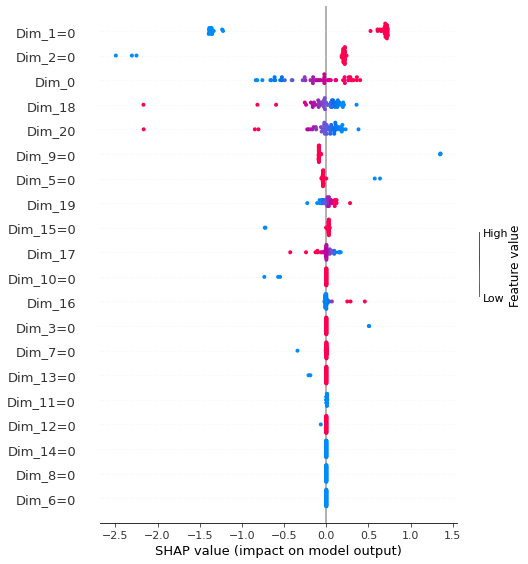

In [9]:
# 各特徴量の予測値への平均寄与率
shap.summary_plot(shap_values[0], samples, plot_type="bar")
# 上記に加えて特徴量の増減と予測値の増減の関係
shap.summary_plot(shap_values[0], samples)

In [10]:
# サンプル毎の各特徴量の予測値への寄与率
shap.force_plot(explainer.expected_value, shap_values[0], samples)